# VAE on spin systems: LR-TFIM

### Importations

In [1]:
from IPython.display import clear_output
clear_output(wait=True)

In [ ]:
import netket as nk
import jax
from netket.operator.spin import sigmax,sigmaz
from jax import numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import flax

### Dataset

In [ ]:
def get_H(J,alpha,h,N=N):#
    """LR-TFIM Hamiltonian with OBC'"""
    hi = nk.hilbert.Spin(s=1/2, N=N)
    H = 0
    for i in range(N):
      for j in range(N):
        if j!=i:
          H -= J*sigmaz(hi,i)*sigmaz(hi,j)/jnp.abs(i-j)**alpha

    H += sum([h*sigmax(hi,i) for i in range(N)])


    return H

In [ ]:
#syst. size
N = 20
hi = nk.hilbert.Spin(s=1/2, N=N)


#define the various observables we want to compute
corr_op = sum([sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])
corr2_op = sum([sigmaz(hi,i)*sigmaz(hi,(i+2)%N) for i in range(N)])
parity_op = 1
for i in range(N):
    parity_op *= sigmaz(hi,i)
magnetization_op = sum([sigmaz(hi,i) for i in range(N)])
magnetization_op *= parity_op



#H parameters
all_alpha = jnp.linspace(1, 5, 20)
all_h = jnp.logspace(0.2, 1.0, 20)

#containers for the observables
energies = jnp.zeros((len(all_alpha),len(all_h)))
wave_fcts = jnp.zeros((len(all_alpha), len(all_h), 2**N, 1))
corr_gs = jnp.zeros((len(all_alpha),len(all_h)))
corr2_gs = jnp.zeros((len(all_alpha),len(all_h)))
magnetization_gs = jnp.zeros((len(all_alpha),len(all_h)))
betas_gs = jnp.zeros((len(all_alpha),len(all_h)))




for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):

        print('alpha: {}, h: {}'.format(alpha,h))
        J = 1
        H = get_H(J,alpha,h,N=N)
        E_gs, ket_gs = nk.exact.lanczos_ed(H, compute_eigenvectors=True)


        corr = (ket_gs.T.conj()@corr_op.to_linear_operator()@ket_gs).real[0,0]
        m = (ket_gs.T.conj()@magnetization_op.to_linear_operator()@ket_gs).real[0,0]
        corr2 = (ket_gs.T.conj()@corr2_op.to_linear_operator()@ket_gs).real[0,0]

        C = []
        for r in range(1,N//2):
          corr_op = sum([sigmaz(hi,i)*sigmaz(hi,(i+r)%N) for i in range(N)])
          corr = (ket_gs.T.conj()@corr_op.to_linear_operator()@ket_gs).real[0,0]/N
          C.append(corr)

        plt.rcParams['font.size'] = 12
        plt.figure(figsize=(4,3),dpi=100)
        plt.plot(jnp.array(list(range(1,N//2))),jnp.abs(jnp.array(C)))
        plt.ylim(-0.1,1.1)
        plt.show()
        plt.figure(figsize=(4,3),dpi=100)
        plt.plot(log_r, log_C, 'o', label='data')
        plt.plot(log_r, intercept + slope * log_r, 'r', label='fit')
        plt.legend()
        plt.show()


        log_C = jnp.log(jnp.abs(jnp.array(C))+1e-3)
        log_r = jnp.log(jnp.array(list(range(1,N//2))))

        slope, intercept = jnp.polyfit(log_r, log_C, 1)
        beta = -slope
        print(beta)

        energies = energies.at[i,j].set(E_gs[0])
        wave_fcts = wave_fcts.at[i,j].set(ket_gs)
        corr_gs = corr_gs.at[i,j].set(corr)
        corr2_gs = corr2_gs.at[i,j].set(corr2)
        magnetization_gs = magnetization_gs.at[i,j].set(m)
        betas_gs = betas_gs.at[i,j].set(beta)




In [ ]:
#save the data
data_exact = {'energies': energies, 'wave_fcts': wave_fcts, 'corr_gs': corr_gs, 'corr2_gs': corr2_gs, 'magnetization_gs': magnetization_gs, 'betas_gs': betas_gs}

with open('data_exact3_CorrTFIM20.pkl', 'wb') as f:
    pickle.dump(data_exact, f)

In [ ]:
with open('data_exact3_CorrTFIM20.pkl', 'rb') as f:
    data_exact = pickle.load(f)

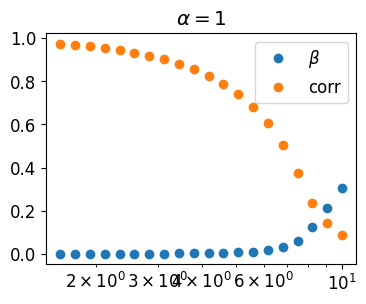

In [ ]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(4,3),dpi=100)
plt.semilogx(all_h,betas_gs[0,:],'o',label=r'$\beta$')
plt.semilogx(all_h,corr_gs[0,:],'o',label=r'corr')
plt.legend()
plt.title(r'$\alpha=1$')
plt.show()

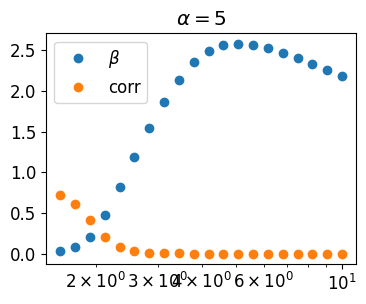

In [ ]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(4,3),dpi=100)
plt.semilogx(all_h,betas_gs[-1,:],'o',label=r'$\beta$')
plt.semilogx(all_h,corr_gs[-1,:],'o',label=r'corr')
plt.legend()
plt.title(r'$\alpha=5$')
plt.show()

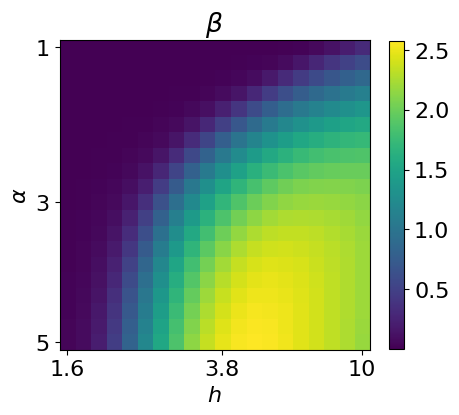

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(5,5),dpi=100)

betas_gs = data_exact['betas_gs']
plt.imshow(betas_gs)
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$h$')
plt.colorbar(shrink=0.8)
plt.title(r'$\beta$')
x_tick_positions = [0, 10, 19]
x_ticks_labels = ['1.6',  '3.8', '10']
plt.xticks(x_tick_positions, x_ticks_labels)

y_tick_positions = [0, 10, 19]
y_ticks_labels = ['1', '3', '5']
plt.yticks(y_tick_positions, y_ticks_labels)
#plt.vlines(55,ymin=0, ymax=68, color='black', linestyles='dashed')
plt.show()

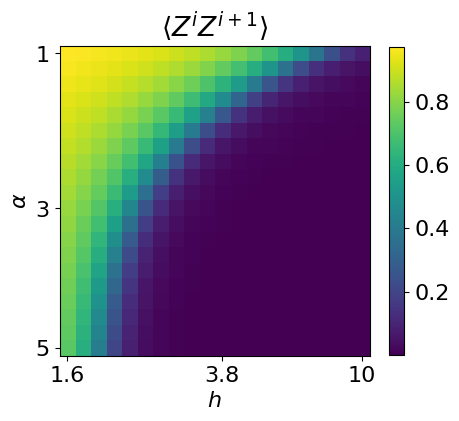

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(5,5),dpi=100)

corr_gs = data_exact['corr_gs']
plt.imshow(corr_gs)
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$h$')
plt.colorbar(shrink=0.8)
plt.title(r'$\langle Z^iZ^{i+1} \rangle$')
x_tick_positions = [0, 10, 19]
x_ticks_labels = ['1.6',  '3.8', '10']
plt.xticks(x_tick_positions, x_ticks_labels)

y_tick_positions = [0, 10, 19]
y_ticks_labels = ['1', '3', '5']
plt.yticks(y_tick_positions, y_ticks_labels)
plt.show()

In [ ]:
#@jax.jit
def sample_spin_configurations(wave_function, num_samples, N, rng_key):
    """sampling spin config. from the exact GS computed by exact diag."""
    wave_function = wave_function.reshape(-1)
    probabilities = jnp.abs(wave_function) ** 2

    # Sample indices based on probabilities
    sampled_indices = jax.random.choice(
        rng_key,
        a=len(probabilities),
        p=probabilities,
        shape=(num_samples,),
        replace=True
    )

    # Convert sampled indices to spin configurations
    def int_to_spin_config(idx):
        return jnp.array([(idx >> i) & 1 for i in range(N)])

    spin_configurations = jax.vmap(int_to_spin_config)(sampled_indices)

    # Convert {0,1} -> {-1,1}
    spin_configurations = 2 * spin_configurations - 1
    return spin_configurations




In [ ]:
#creat the dataset

is_test_set = False
N = 20

num_sample_per_params = 50000
all_alpha = jnp.linspace(1, 5, 20)
all_h = jnp.logspace(0.2, 1.0, 20)
dataset = jnp.zeros([jnp.size(all_alpha), jnp.size(all_h), num_sample_per_params, N])

key = jax.random.PRNGKey(0+is_test_set*10)

wave_fcts = data_exact['wave_fcts']

for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):
      print('alpha: {}, h: {}'.format(alpha,h))
      key, subkey = jax.random.split(key)
      samples = sample_spin_configurations(wave_fcts[i,j], num_samples=num_sample_per_params, N=N, rng_key=key)
      dataset = dataset.at[i,j].set(samples)

jnp.shape(dataset)

alpha: 1.0, h: 1.5848931924611136
alpha: 1.0, h: 1.7462453520016197
alpha: 1.0, h: 1.9240241827602391
alpha: 1.0, h: 2.119902023849609
alpha: 1.0, h: 2.3357214690901222
alpha: 1.0, h: 2.5735127000169102
alpha: 1.0, h: 2.835512583496651
alpha: 1.0, h: 3.124185713602666
alpha: 1.0, h: 3.44224759568609
alpha: 1.0, h: 3.79269019073225
alpha: 1.0, h: 4.178810060294221
alpha: 1.0, h: 4.604239376758781
alpha: 1.0, h: 5.0729800906537275
alpha: 1.0, h: 5.589441576403376
alpha: 1.0, h: 6.158482110660264
alpha: 1.0, h: 6.785454573393578
alpha: 1.0, h: 7.4762568016376845
alpha: 1.0, h: 8.237387069571014
alpha: 1.0, h: 9.076005216818142
alpha: 1.0, h: 10.0
alpha: 1.2105263157894737, h: 1.5848931924611136
alpha: 1.2105263157894737, h: 1.7462453520016197
alpha: 1.2105263157894737, h: 1.9240241827602391
alpha: 1.2105263157894737, h: 2.119902023849609
alpha: 1.2105263157894737, h: 2.3357214690901222
alpha: 1.2105263157894737, h: 2.5735127000169102
alpha: 1.2105263157894737, h: 2.835512583496651
alpha: 

(20, 20, 500, 20)

In [ ]:
with open('dataset_CorrTFIM20.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [ ]:
def compute_beta_power_law_from_spins(x):
  """compute the beta exponent from spin configurations"""
  N = x.shape[-1]
  correlations = []
  for r in range(1, N // 2):
    # Calculate correlation for current r
    correlation = jnp.mean(x * jnp.roll(x, -r))#, axis=-1) #directly does the mean over the batch for better results
    correlations.append(correlation)
  C = jnp.array(correlations)
  log_C = jnp.log(jnp.abs(C)+1e-3)
  log_r = jnp.log(jnp.array(list(range(1,N//2))))

  slope, intercept = jnp.polyfit(log_r, log_C, 1)
  beta = -slope
  return beta

compute_beta_power_law_from_spins_vmap = jax.vmap(jax.vmap(compute_beta_power_law_from_spins))

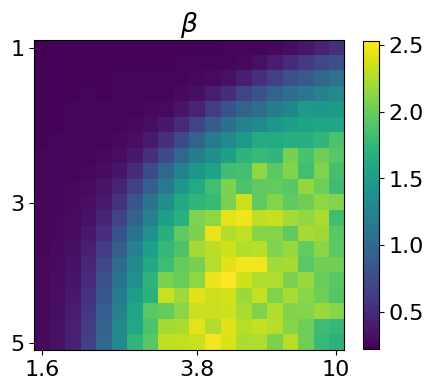

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(5,5),dpi=100)

beta = compute_beta_power_law_from_spins_vmap(dataset)

plt.imshow(beta)#,vmin=0)
plt.title(r'$\beta$')
plt.colorbar(shrink=0.8)
x_tick_positions = [0, 10, 19]
x_ticks_labels = ['1.6',  '3.8', '10']
plt.xticks(x_tick_positions, x_ticks_labels)

y_tick_positions = [0, 10, 19]
y_ticks_labels = ['1', '3', '5']
plt.yticks(y_tick_positions, y_ticks_labels)
plt.show()

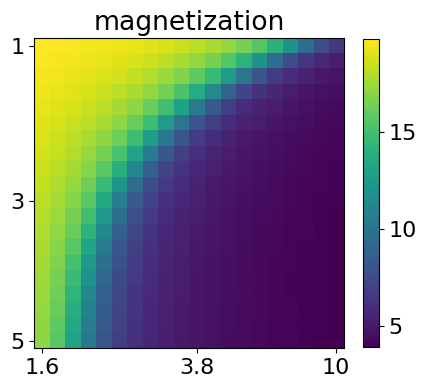

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(5,5),dpi=100)

m = jnp.mean(jnp.abs(jnp.sum(dataset, axis=-1)), axis=-1)

plt.imshow(m)
plt.title(r'magnetization')
plt.colorbar(shrink=0.8)
x_tick_positions = [0, 10, 19]
x_ticks_labels = ['1.6',  '3.8', '10']
plt.xticks(x_tick_positions, x_ticks_labels)

y_tick_positions = [0, 10, 19]
y_ticks_labels = ['1', '3', '5']
plt.yticks(y_tick_positions, y_ticks_labels)
plt.show()

In [ ]:
is_test_set = True
N = 20

num_sample_per_params = 50000
all_alpha = jnp.linspace(1, 5, 20)
all_h = jnp.logspace(0.2, 1.0, 20)
testset = jnp.zeros([jnp.size(all_alpha), jnp.size(all_h), num_sample_per_params, N])

key = jax.random.PRNGKey(0+is_test_set*10)

wave_fcts = data_exact['wave_fcts']

for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):
      print('alpha: {}, h: {}'.format(alpha,h))
      key, subkey = jax.random.split(key)
      samples = sample_spin_configurations(wave_fcts[i,j], num_samples=num_sample_per_params, N=N, rng_key=key)
      testset = testset.at[i,j].set(samples)

jnp.shape(testset)

alpha: 1.0, h: 1.5848931924611136
alpha: 1.0, h: 1.7462453520016197
alpha: 1.0, h: 1.9240241827602391
alpha: 1.0, h: 2.119902023849609
alpha: 1.0, h: 2.3357214690901222
alpha: 1.0, h: 2.5735127000169102
alpha: 1.0, h: 2.835512583496651
alpha: 1.0, h: 3.124185713602666
alpha: 1.0, h: 3.44224759568609
alpha: 1.0, h: 3.79269019073225
alpha: 1.0, h: 4.178810060294221
alpha: 1.0, h: 4.604239376758781
alpha: 1.0, h: 5.0729800906537275
alpha: 1.0, h: 5.589441576403376
alpha: 1.0, h: 6.158482110660264
alpha: 1.0, h: 6.785454573393578
alpha: 1.0, h: 7.4762568016376845
alpha: 1.0, h: 8.237387069571014
alpha: 1.0, h: 9.076005216818142
alpha: 1.0, h: 10.0
alpha: 1.2105263157894737, h: 1.5848931924611136
alpha: 1.2105263157894737, h: 1.7462453520016197
alpha: 1.2105263157894737, h: 1.9240241827602391
alpha: 1.2105263157894737, h: 2.119902023849609
alpha: 1.2105263157894737, h: 2.3357214690901222
alpha: 1.2105263157894737, h: 2.5735127000169102
alpha: 1.2105263157894737, h: 2.835512583496651
alpha: 

(20, 20, 50000, 20)

### Determ decoder

#### Code

In [ ]:
import optax
from flax import linen as nn


class CircularConv1D(nn.Module):
    """Custom conv. layer to apply a circular padding"""
    features: int
    kernel_size: int
    strides: int = 1
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        # x shape: (batch, length, channels)
        pad_size = self.kernel_size // 2
        # Circular padding along the spin chain
        x = jnp.pad(x, ((0, 0), (pad_size, pad_size), (0, 0)), mode='wrap')
        # 1D conv.
        x = nn.Conv(
            features=self.features,
            kernel_size=(self.kernel_size,),
            strides=(self.strides,),
            padding='VALID',
            use_bias=self.use_bias
        )(x)
        return x


class EncoderCNN(nn.Module):
    """Conv. encoder module"""
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))  # Reshape to (batch, N, 1)
        # Conv.blocks
        x = CircularConv1D(features=32, kernel_size=3, strides=1)(x)
        x = nn.relu(x)

        x = CircularConv1D(features=32, kernel_size=3, strides=1)(x)
        x = nn.relu(x)

        # Global Average Pooling over the spatial dimension (axis=1)
        x = x.mean(axis=1)  # x has shape (batch, features)

        # Dense layers
        mean = nn.Dense(features=64)(x)
        mean = nn.relu(mean)
        mean = nn.Dense(features=self.latent_dim)(mean)

        logvar = nn.Dense(features=64)(x)
        logvar = nn.relu(logvar)
        logvar = nn.Dense(features=self.latent_dim)(logvar)


        return mean, logvar


class Decoder(nn.Module):
    """Decoder module of the dVAE"""
    @nn.compact
    def __call__(self, z):

        N = 20
        alpha = 4

        z = nn.Dense(N*alpha)(z)
        z = nn.relu(z)
        z = nn.Dense(N*alpha)(z)
        z = nn.relu(z)
        z = nn.tanh(nn.Dense(N)(z))
        return z


# VAE model definition
class VAE(nn.Module):
    latent_dim: int
    kernel_size: int = 3

    def setup(self):
        self.encoder = EncoderCNN(self.latent_dim,self.kernel_size)
        self.decoder = Decoder()

    def reparameterize(self, mean, logvar, key):
        # Reparameterization trick
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(key, mean.shape)
        return mean + eps * std

    def __call__(self, x, key):

        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar, key)
        recon_x = self.decoder(z)

        return recon_x, mean, logvar, z


### LOSS ###


#code inspired from the following pytorch implementation https://github.com/YannDubs/disentangling-vae/tree/master

def log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian."""
    normalization = -0.5 * (jnp.log(2 * jnp.pi) + logvar)
    inv_var = jnp.exp(-logvar)
    log_density = normalization - 0.5 * ((x - mu) ** 2 * inv_var)
    return log_density

def matrix_log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian for all batch pairs."""
    batch_size, dim = x.shape
    x = x[:, None, :]
    mu = mu[None, :, :]
    logvar = logvar[None, :, :]
    return log_density_gaussian(x, mu, logvar)

def log_importance_weight_matrix(batch_size, dataset_size):
    """Calculates a log importance weight matrix."""
    N = dataset_size
    M = batch_size - 1
    strat_weight = (N - M) / (N * M)
    W = jnp.full((batch_size, batch_size), 1 / M)
    W = W.at[jnp.diag_indices(batch_size)].set(1 / N)
    W = W.at[jnp.arange(1, batch_size), jnp.arange(batch_size - 1)].set(strat_weight)
    W = W.at[M - 1, 0].set(strat_weight)
    return jnp.log(W)

def _get_log_pz_qz_prodzi_qzCx(latent_sample, latent_dist, n_data, is_mss=True):
    batch_size, hidden_dim = latent_sample.shape

    # calculate log q(z|x)
    log_q_zCx = log_density_gaussian(latent_sample, *latent_dist).sum(axis=1)

    # calculate log p(z) (standard normal prior)
    zeros = jnp.zeros_like(latent_sample)
    log_pz = log_density_gaussian(latent_sample, zeros, zeros).sum(axis=1)

    mat_log_qz = matrix_log_density_gaussian(latent_sample, *latent_dist)

    if is_mss:
        # use stratification
        log_iw_mat = log_importance_weight_matrix(batch_size, n_data)
        mat_log_qz = mat_log_qz + log_iw_mat[:, :, None]

    log_qz = jax.scipy.special.logsumexp(mat_log_qz.sum(axis=2), axis=1)
    log_prod_qzi = jax.scipy.special.logsumexp(mat_log_qz, axis=1).sum(axis=1)

    return log_pz, log_qz, log_prod_qzi, log_q_zCx



def compute_loss(params, batch, alpha, beta, gamma, key):
    """Compute the VAE loss."""

    loss = 0

    recon_x, mean, logvar, z = vae.apply({'params': params}, batch, key)

    # Reconstruction loss (Mean Squared Error)
    x =  batch
    recon_loss = jnp.mean(jnp.square(x - recon_x))


    # KL-divergence loss
    kl_loss = -beta * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

    log_pz, log_qz, log_prod_qzi, log_q_zCx  = _get_log_pz_qz_prodzi_qzCx(latent_sample=z, latent_dist=(mean,logvar), n_data=jnp.shape(z)[0], is_mss=True)

    mi_loss = (log_q_zCx - log_qz).mean()
    tc_loss = (log_qz - log_prod_qzi).mean()
    dw_kl_loss = (log_prod_qzi - log_pz).mean()


    loss = recon_loss + alpha*mi_loss + beta*tc_loss + gamma*dw_kl_loss

    return loss/jnp.shape(x)[0]




val_grad_fn = jax.jit(jax.value_and_grad(compute_loss))





@jax.jit
def MSE_loss(params, batch, key):

    recon_x, mean, logvar, _ = vae.apply({'params': params}, batch, key)
    x = batch
    recon_loss = jnp.mean(jnp.square(x - recon_x))

    return recon_loss/jnp.shape(x)[0]

@jax.jit
def KL_loss(params, batch, key):

    recon_x, mean, logvar, _ = vae.apply({'params': params}, batch, key)
    beta = 1.
    kl_loss = -beta * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    loss = kl_loss
    x = batch
    return loss/jnp.shape(x)[0]


### TRAIN SET ###

def batch_data(dataset, batch_size):
  num_samples = dataset.shape[0]
  num_batches = num_samples // batch_size
  batches = []
  for i in range(num_batches):
    batch = dataset[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return batches

def batch_data_suffled(dataset, batch_size, key):
  """From the training set, creat batches with spin config coming from GS of H with various params."""

  num_samples = dataset.shape[0]
  # Create a permutation of indices
  permutation = jax.random.permutation(key, jnp.arange(num_samples))
  # Shuffle the dataset
  shuffled_dataset = dataset[permutation]
  # Create batches from the shuffled dataset
  num_batches = num_samples // batch_size
  batches = []
  for i in range(num_batches):
    batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return batches


batches = batch_data_suffled(dataset.reshape(-1,N), batch_size=10000, key=jax.random.PRNGKey(123567))
batches = jax.device_put(batches)


def lin_annealing(step, total_steps, max, min):
  """linear schedule used for the gamma hyperparams in the TC loss"""
  gamma = max - (step / total_steps) * (max - min)
  return gamma



#### Training

alpha: 0.0, beta: 0.0, gamma_max: 0
step: 0, loss: 0.0001158290000181705, KL: 0.0840048359561997, MSE: 0.00011273668328504341
logvar: [ 0.25209351 -0.07636617]
step: 1, loss: 6.574541904560325e-05, KL: 28.957104363974988, MSE: 6.573035867025117e-05
logvar: [-6.9240958  -9.21798148]


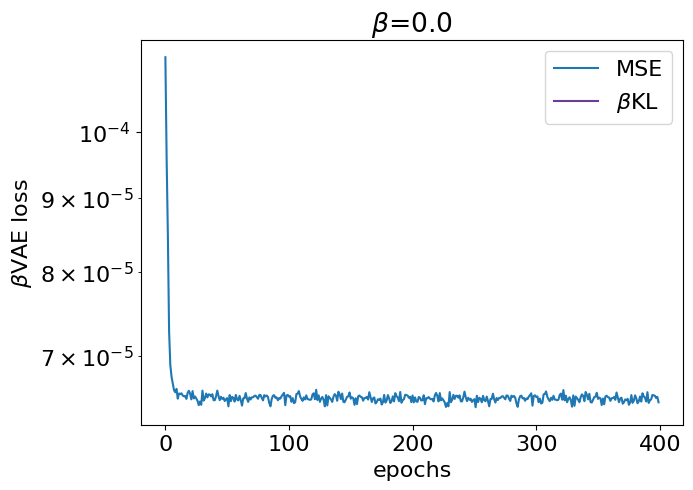

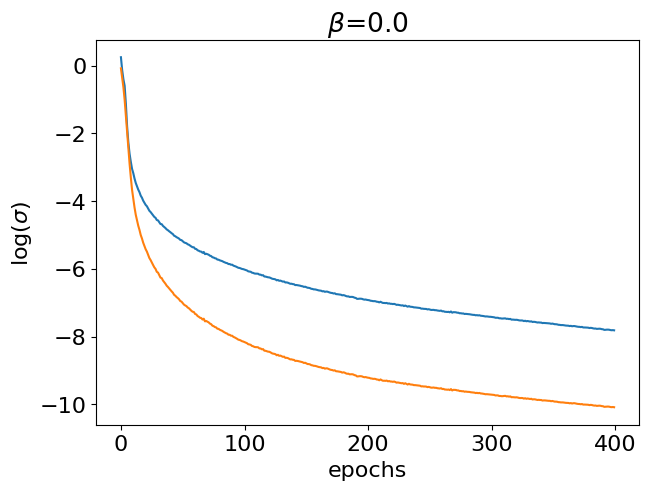

In [ ]:
alpha = 0.0
gamma_min = 0.00001
alphas = [0.0]
betas = [0.]
gammas = [0]

for m in range(1): #if we want to average over many models


    for alpha in alphas:
      for beta in betas:
        for gamma_max in gammas:


            print('alpha: {}, beta: {}, gamma_max: {}'.format(alpha, beta, gamma_max))


            ### INITIALIZATION ###

            input_init = batches[0]
            rng = jax.random.PRNGKey(1234+m)
            key_init = jax.random.PRNGKey(124+m)
            key = jax.random.PRNGKey(12+m)



            latent_dim = 2
            vae = VAE(latent_dim=latent_dim,kernel_size=3)
            params = vae.init(rng, input_init, key_init)['params']
            params = jax.device_put(params)

            lr = 0.001
            opt = optax.adabelief(learning_rate=lr)
            opt_state = opt.init(params)

            history_loss = []
            history_loss_KL = []
            history_loss_MSE = []
            history_loss_MI = []
            history_loss_TC = []
            history_loss_DW = []


            num_epochs = 2


            history_logvar = []




            ### TRAINING ###


            for i in range(num_epochs):
              for j, batch in enumerate(batches):

                key = jax.random.split(key)[0]

                num_epochs_max = 100

                gamma = lin_annealing(i*40+j, 40*num_epochs_max, gamma_min, gamma_max)

                val, grad = val_grad_fn(params, batch, alpha, beta, gamma, key)
                updates, opt_state = opt.update(grad, opt_state, params)
                params = optax.apply_updates(params, updates)

                if j%10==0:
                      history_loss.append(val.tolist())
                      KL = KL_loss(params, batch, key).tolist()
                      history_loss_KL.append(KL)
                      MSE = MSE_loss(params, batch, key).tolist()
                      history_loss_MSE.append(MSE)


                      recon_x, mean, logvar, z = vae.apply({'params': params}, batch, key)
                      history_logvar.append(logvar)

                if i%1==0 and j==0:
                      print("step: {}, loss: {}, KL: {}, MSE: {}".format(i,val,KL,MSE))
                      print("logvar: {}".format(jnp.mean(logvar, axis=0)))



            history_logvar = jnp.array(history_logvar)

            plt.rcParams['font.size'] = 16
            plt.figure(figsize=(7,5),dpi=100)

            #beta = 5e-5
            #plt.semilogy(jnp.array(history_loss_KL)*0+13*beta,color=sns.color_palette('Paired')[9], label="KL")
            plt.semilogy(history_loss_MSE,color=sns.color_palette('Paired')[1], label="MSE")
            plt.semilogy(beta*jnp.array(history_loss_KL),color=sns.color_palette('Paired')[9], label=r'$\beta$KL')
            #plt.semilogy(jnp.array(history_loss_MSE)+beta*jnp.array(history_loss_KL),color=sns.color_palette('Paired')[0], label="tot")
            plt.legend()
            #plt.xlim([-10,500])
            plt.xlabel('epochs')
            plt.ylabel(r'$\beta$VAE loss')
            plt.title(r'$\beta$='+str(beta))
            plt.show()

            plt.rcParams['font.size'] = 16
            plt.figure(figsize=(7,5),dpi=100)

            plt.plot([jnp.mean(history_logvar[i], axis=0) for i in range(len(history_logvar))])
            plt.xlabel('epochs')
            plt.ylabel(r'$\log(\sigma)$')
            plt.title(r'$\beta$='+str(beta))
            plt.show()

            data = {'params': params, 'history_loss': history_loss, 'history_loss_KL': history_loss_KL, 'history_loss_MSE': history_loss_MSE, 'beta':beta, 'history_logvar': history_logvar}
            with open('CorrTFIM20_dataset3_data_model_DETconv_woKL2lat.pkl', 'wb') as f:
                pickle.dump(data, f)




#### Results

In [ ]:
with open('CorrTFIM20_dataset3_data_model_DETconv_woKL2lat.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
latent_dim = 2
vae = VAE(latent_dim=latent_dim,kernel_size=3)

In [ ]:
## GET THE MEAN AND LOGVAR AFTER TRAINING FOR THE WHOLE DATASET


J1 = -1.


all_alpha = jnp.linspace(0, 10, 20)
all_h = jnp.linspace(0, 20.0, 20)

N = 20

#testset = dataset

latent_dim = 2

vae = VAE(latent_dim=latent_dim,kernel_size=3)


all_mean = jnp.zeros((len(all_alpha),len(all_h),latent_dim))
all_mean_abs = jnp.zeros((len(all_alpha),len(all_h),latent_dim))
all_logvar = jnp.zeros((len(all_alpha),len(all_h),latent_dim))
all_all_mean = jnp.zeros((len(all_alpha),len(all_h),jnp.shape(dataset)[2],latent_dim))
all_recon_x = jnp.zeros((len(all_alpha),len(all_h),jnp.shape(dataset)[2],N))

params = data['params']

key = jax.random.PRNGKey(123)

for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):

      d = testset[i,j]
      key = jax.random.split(key)[0]
      recon_x, means, logvar, _ = vae.apply({'params': params}, d, key)

      all_mean = all_mean.at[i,j].set(jnp.mean(means,axis=0))
      all_all_mean = all_all_mean.at[i,j].set(means)
      all_logvar = all_logvar.at[i,j].set(jnp.mean(logvar,axis=0))
      all_recon_x = all_recon_x.at[i,j].set(recon_x)

# sort the logvar
idx = jnp.argsort(jnp.mean(all_logvar, axis=(0,1)))


In [ ]:
latvar = {'mu0': all_all_mean[:,:,:,idx[0]], 'mu1': all_all_mean[:,:,:,idx[1]], 'logvar0': all_logvar[:,:,idx[0]], 'logvar1': all_logvar[:,:,idx[1]]}

with open('LRTFIM20_latentvar_DETconv.pkl', 'wb') as f:
  pickle.dump(latvar, f)

In [ ]:
key = jax.random.PRNGKey(675849)
all_recon_x = jax.random.bernoulli(key, (all_recon_x+1)/2, shape=jnp.shape(all_recon_x))*2-1

with open('LRTFIM20_recon_x_DETconv.pkl', 'wb') as f:
  pickle.dump(all_recon_x, f)

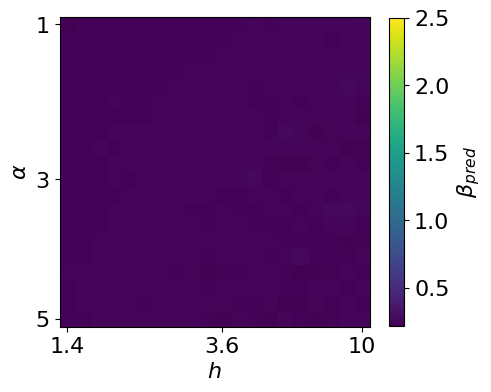

In [ ]:
import seaborn as sns
plt.rcParams['font.size'] = 16
plt.figure(figsize=(5,5),dpi=100)

all_S_phase_space = jax.random.bernoulli(key, (all_recon_x+1)/2, shape=jnp.shape(all_recon_x))*2-1
b = compute_beta_power_law_from_spins_vmap(all_S_phase_space)
plt.imshow(b, vmax=2.5)#, cmap=sns.color_palette("flare", as_cmap=True))
cbar = plt.colorbar(shrink = 0.8)
cbar.set_label(r'$\beta_{pred}$')

plt.ylabel(r'$\alpha$')
plt.xlabel(r'$h$')

x_tick_positions = [0, 10, 19]
x_ticks_labels = ['1.4',  '3.6', '10']
plt.xticks(x_tick_positions, x_ticks_labels)

y_tick_positions = [0, 10, 19]
y_ticks_labels = ['1', '3', '5']
plt.yticks(y_tick_positions, y_ticks_labels)
plt.show()

### Proba decoder

#### code

In [ ]:
import optax
from flax import linen as nn
from functools import partial
from netket import jax as nkjax
from modified_nk_ARNN import *

class CircularConv1D(nn.Module):
    """Custom conv. layer to apply a circular padding"""
    features: int
    kernel_size: int
    strides: int = 1
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        # x shape: (batch, length, channels)
        pad_size = self.kernel_size // 2
        # Circular padding along the spin chain
        x = jnp.pad(x, ((0, 0), (pad_size, pad_size), (0, 0)), mode='wrap')
        # 1D conv.
        x = nn.Conv(
            features=self.features,
            kernel_size=(self.kernel_size,),
            strides=(self.strides,),
            padding='VALID',
            use_bias=self.use_bias
        )(x)
        return x


class EncoderCNN(nn.Module):
    """Conv. encoder module"""
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))  # Reshape to (batch, N, 1)
        # Conv.blocks
        x = CircularConv1D(features=32, kernel_size=3, strides=1)(x)
        x = nn.relu(x)

        x = CircularConv1D(features=32, kernel_size=3, strides=1)(x)
        x = nn.relu(x)

        # Global Average Pooling over the spatial dimension (axis=1)
        x = x.mean(axis=1)  # x has shape (batch, features)

        # Dense layers
        mean = nn.Dense(features=64)(x)
        mean = nn.relu(mean)
        mean = nn.Dense(features=self.latent_dim)(mean)

        logvar = nn.Dense(features=64)(x)
        logvar = nn.relu(logvar)
        logvar = nn.Dense(features=self.latent_dim)(logvar)


        return mean, logvar



class Encoder_and_latent(nn.Module):
    """Module combining the encoder and the reparam. trick of the latent space"""
    latent_dim: int
    kernel_size: int = 3

    def setup(self):
        self.encoder = EncoderCNN(self.latent_dim, self.kernel_size)



    def reparameterize(self, mean, logvar, key):
        # Reparameterization trick
        std = jnp.exp(0.5 * logvar)
        #std = jnp.exp(logvar)
        eps = jax.random.normal(key, mean.shape)
        return mean + eps * std

    def __call__(self, x, key):

        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar, key)

        return mean, logvar, z






def log_normal_pdf(mu, logvar, sample):
    return -0.5 * ((sample - mu) ** 2 * jnp.exp(-logvar) + logvar + jnp.log(2. * jnp.pi))


def log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian."""
    normalization = -0.5 * (jnp.log(2 * jnp.pi) + logvar)
    inv_var = jnp.exp(-logvar)
    log_density = normalization - 0.5 * ((x - mu) ** 2 * inv_var)
    return log_density


#code inspired from the following pytorch implementation https://github.com/YannDubs/disentangling-vae/tree/master


def matrix_log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian for all batch pairs."""
    batch_size, dim = x.shape
    x = x[:, None, :]
    mu = mu[None, :, :]
    logvar = logvar[None, :, :]
    return log_density_gaussian(x, mu, logvar)

def log_importance_weight_matrix(batch_size, dataset_size):
    """Calculates a log importance weight matrix."""
    N = dataset_size
    M = batch_size - 1
    strat_weight = (N - M) / (N * M)
    W = jnp.full((batch_size, batch_size), 1 / M)
    W = W.at[jnp.diag_indices(batch_size)].set(1 / N)
    W = W.at[jnp.arange(1, batch_size), jnp.arange(batch_size - 1)].set(strat_weight)
    W = W.at[M - 1, 0].set(strat_weight)
    return jnp.log(W)

def _get_log_pz_qz_prodzi_qzCx(latent_sample, latent_dist, n_data, is_mss=True):
    batch_size, hidden_dim = latent_sample.shape

    # calculate log q(z|x)
    log_q_zCx = log_density_gaussian(latent_sample, *latent_dist).sum(axis=1)

    # calculate log p(z) (standard normal prior)
    zeros = jnp.zeros_like(latent_sample)
    log_pz = log_density_gaussian(latent_sample, zeros, zeros).sum(axis=1)

    mat_log_qz = matrix_log_density_gaussian(latent_sample, *latent_dist)

    if is_mss:
        # use stratification
        log_iw_mat = log_importance_weight_matrix(batch_size, n_data)
        mat_log_qz = mat_log_qz + log_iw_mat[:, :, None]

    log_qz = jax.scipy.special.logsumexp(mat_log_qz.sum(axis=2), axis=1)
    log_prod_qzi = jax.scipy.special.logsumexp(mat_log_qz, axis=1).sum(axis=1)

    return log_pz, log_qz, log_prod_qzi, log_q_zCx





def compute_loss(params, batch, alpha, beta, gamma, key):
    """VAE loss"""


    params_encoder, params_decoder = params


    mean, logvar, z  = enc_lat.apply({'params': params_encoder}, batch, key)
    key = jax.random.split(key)[0]


    # Reconstruction loss
    x = batch
    inputs = jnp.concatenate((z, x), axis=1)
    p_i = decoder.apply(params_decoder, inputs, method=decoder.conditionals)[:,latent_dim:,:]
    eps = 1e-10
    log_p = (1-x)/2*jnp.log(p_i[:,:,0]+eps) + (1+x)/2*jnp.log(p_i[:,:,1]+eps)
    recon_loss = -jnp.sum(log_p)/jnp.shape(x)[0]  #double sum over samples in batch and spatial dimension


    #KL loss
    log_pz, log_qz, log_prod_qzi, log_q_zCx  = _get_log_pz_qz_prodzi_qzCx(latent_sample=z, latent_dist=(mean,logvar), n_data=jnp.shape(z)[0], is_mss=True)

    mi_loss = (log_q_zCx - log_qz).mean()
    tc_loss = (log_qz - log_prod_qzi).mean()
    dw_kl_loss = (log_prod_qzi - log_pz).mean()


    loss = recon_loss + alpha*mi_loss + beta*tc_loss + gamma*dw_kl_loss

    return loss


val_grad_fn = jax.jit(jax.value_and_grad(compute_loss))







@jax.jit
def RC_loss(params, batch, key):


    params_encoder, params_decoder = params

    key = jax.random.split(key)[0]
    mean, logvar, z  = enc_lat.apply({'params': params_encoder}, batch, key)

    # Reconstruction loss
    x = batch
    inputs = jnp.concatenate((z, x), axis=1)
    eps = 1e-10
    p_i = decoder.apply(params_decoder, inputs, method=decoder.conditionals)[:,latent_dim:,:]
    log_p = (1-x)/2*jnp.log(p_i[:,:,0]+eps) + (1+x)/2*jnp.log(p_i[:,:,1]+eps) #last term: p_i[:,:,1] = 1-p_i[:,:,0]
    recon_loss = -jnp.sum(log_p) #double sum over samples in batch and spatial dimension

    return recon_loss/jnp.shape(x)[0]





@jax.jit
def KL_loss(params, batch, key):

    params_encoder, params_decoder = params
    key = jax.random.split(key)[0]
    mean, logvar, z  = enc_lat.apply({'params': params_encoder}, batch, key)

    kl = -0.5*jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    C = 0
    kl_loss = beta * jnp.abs(kl-C)
    loss = kl_loss
    x = batch
    return loss/jnp.shape(x)[0]



def batch_data(dataset, batch_size):
  num_samples = dataset.shape[0]
  num_batches = num_samples // batch_size
  batches = []
  for i in range(num_batches):
    batch = dataset[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return batches

def batch_data_suffled(dataset, batch_size, key):
  """From the training set, creat batches with spin config coming from GS of H with various params."""
  num_samples = dataset.shape[0]
  # Create a permutation of indices
  permutation = jax.random.permutation(key, jnp.arange(num_samples))
  # Shuffle the dataset
  shuffled_dataset = dataset[permutation]
  # Create batches from the shuffled dataset
  num_batches = num_samples // batch_size
  batches = []
  for i in range(num_batches):
    batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return batches



def lin_annealing(step, total_steps, max, min):
  beta = max - (step / total_steps) * (max - min)
  return beta


N = 20


batches = batch_data_suffled(dataset.reshape(-1,N), batch_size=10000, key=jax.random.PRNGKey(123567))
batches = jax.device_put(batches)
input_init = batches[0]




#### training

kernel_size: 3, beta: 0.5,  gamma_max: 10.0, gamma_min: 0.5, alpha:0.1
step: 0, loss: 7.5069876113739, bKL: 0.19787228702456527, RC: 40.43541253011801
logvar: [ 0.40755136  0.36452118  0.16141871  0.1901687  -0.18343008]
step: 1, loss: -6.066074983334115, bKL: 1.6926855697470586, RC: 8.205565019100998
logvar: [-6.72489802e+00 -3.01974201e-05 -3.98536915e-02  6.16002263e-03
 -3.88665841e-02]
step: 2, loss: -6.780497612646857, bKL: 2.383120666251921, RC: 7.340916158868806
logvar: [-6.51105742 -0.04878385 -0.01300055  0.00838033 -3.01831491]
step: 3, loss: -6.990342939198477, bKL: 2.5708822616423843, RC: 7.0497749794571725
logvar: [-6.68066175e+00  3.12985302e-03 -3.30287782e-02 -8.11141405e-03
 -3.59046018e+00]


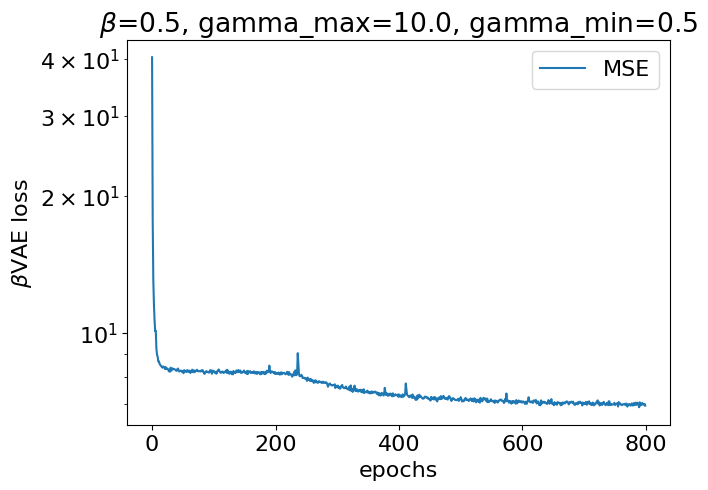

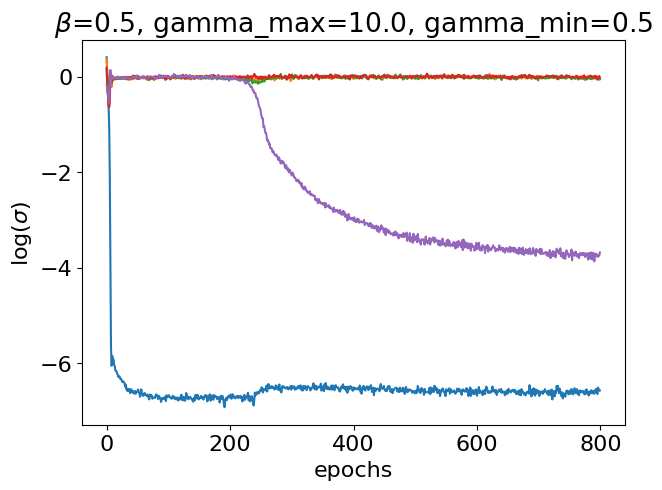

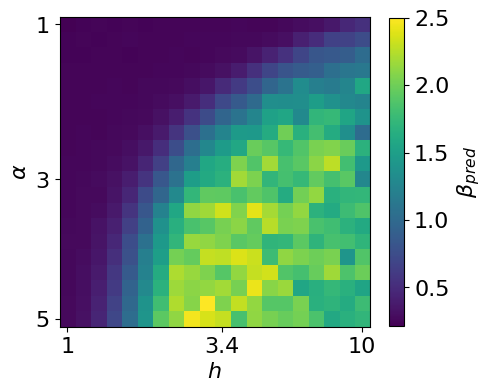

In [ ]:
alpha = 0.1

k = 0
for  gamma_max in [10.]:
  for gamma_min in [0.5]:
    for kernel_size in [3]:
      for beta in [0.5]:



        print('kernel_size: {}, beta: {},  gamma_max: {}, gamma_min: {}, alpha:{}'.format(kernel_size, beta,gamma_max, gamma_min, alpha))

        m = 0

        ### INITIALIZATION ###

        #keys
        input_init = batches[0]
        rng = jax.random.PRNGKey(1234+m)
        key_init = jax.random.PRNGKey(124+m)
        key = jax.random.PRNGKey(12+m)


        #parameters of the VAE
        latent_dim =  5
        #kernel_size = 5
        enc_lat = Encoder_and_latent(latent_dim=latent_dim,kernel_size=kernel_size)
        params_encoder = enc_lat.init(rng, input_init, key_init)['params']

        N = 20
        hi = nk.hilbert.Spin(s=1/2, N=N)
        decoder = ARNNDense(hilbert=hi, layers=3, features=4*N)
        params_decoder = decoder.init(jax.random.PRNGKey(0), jnp.ones((1, N+latent_dim)))

        params = (params_encoder, params_decoder)


        #Optimizer
        lr = 0.001
        opt = optax.adabelief(learning_rate=lr)
        opt_state = opt.init(params)


        #Containers to store the values of the losses during the training
        history_loss = []
        history_loss_KL = []
        history_loss_RC = []
        history_loss_MI = []
        history_loss_TC = []
        history_loss_DW = []
        history_logvar = []


        num_epochs = 4



        ### TRAINING ###

        for i in range(num_epochs):
          for j, batch in enumerate(batches):

            key = jax.random.split(key)[0]
            tot_num_epochs = 5
            gamma = lin_annealing(i*jnp.shape(batches)[0]+j, jnp.shape(batches)[0]*tot_num_epochs, gamma_min, gamma_max)


            val, grad = val_grad_fn(params, batch, alpha, beta, gamma, key)
            updates, opt_state = opt.update(grad, opt_state, params)
            params = optax.apply_updates(params, updates)

            if j%10==0:
                  history_loss.append(val.tolist())
                  KL = KL_loss(params, batch, key).tolist()
                  history_loss_KL.append(KL)
                  RC = RC_loss(params, batch, key).tolist()
                  history_loss_RC.append(RC)


                  mean, logvar, z = enc_lat.apply({'params': params[0]}, batch, key)
                  history_logvar.append(logvar)


            if i%1==0 and j==0:
                  print("step: {}, loss: {}, bKL: {}, RC: {}".format(i,val,KL,RC))
                  print("logvar: {}".format(jnp.mean(logvar, axis=0)))







        history_logvar = jnp.array(history_logvar)

        plt.rcParams['font.size'] = 16
        plt.figure(figsize=(7,5),dpi=100)

        plt.semilogy(history_loss_RC,color=sns.color_palette('Paired')[1], label="MSE")
        #plt.semilogy(beta*jnp.array(history_loss_KL),color=sns.color_palette('Paired')[9], label=r'$\beta$KL')

        plt.legend()
        #plt.xlim([-10,500])
        plt.xlabel('epochs')
        plt.ylabel(r'$\beta$VAE loss')
        plt.title(r'$\beta$={}, gamma_max={}, gamma_min={}'.format(beta,gamma_max, gamma_min))
        plt.show()

        plt.rcParams['font.size'] = 16
        plt.figure(figsize=(7,5),dpi=100)

        plt.plot([jnp.mean(history_logvar[i], axis=0) for i in range(len(history_logvar))])
        plt.xlabel('epochs')
        plt.ylabel(r'$\log(\sigma)$')
        plt.title(r'$\beta$={}, gamma_max={}, gamma_min={}'.format(beta,gamma_max, gamma_min))
        plt.show()

        data = {'params': params, 'history_loss': history_loss, 'history_loss_KL': history_loss_KL, 'history_loss_RC': history_loss_RC, 'history_logvar': history_logvar}
        with open('LRFIM20_dataset3_data_model_ARconv_beta{}_gammamax{}_ gamma_min{}_kernelsize{}_alpha{}.pkl'.format(beta,gamma_max, gamma_min,kernel_size,alpha), 'wb') as f:
            pickle.dump(data, f)



In [ ]:
data = {'params': params, 'history_loss': history_loss, 'history_loss_KL': history_loss_KL, 'history_loss_RC': history_loss_RC, 'history_loss_DW': history_loss_DW, 'history_loss_MI': history_loss_MI, 'history_loss_MI': history_loss_MI, 'history_loss_TC': history_loss_TC, 'alpha_beta_gamma':[alpha, beta, gamma], 'history_logvar': history_logvar}
with open('LRFIM20_dataset3_data_model_AR_woKL.pkl', 'wb') as f:
    pickle.dump(data, f)

#### results

##### Training

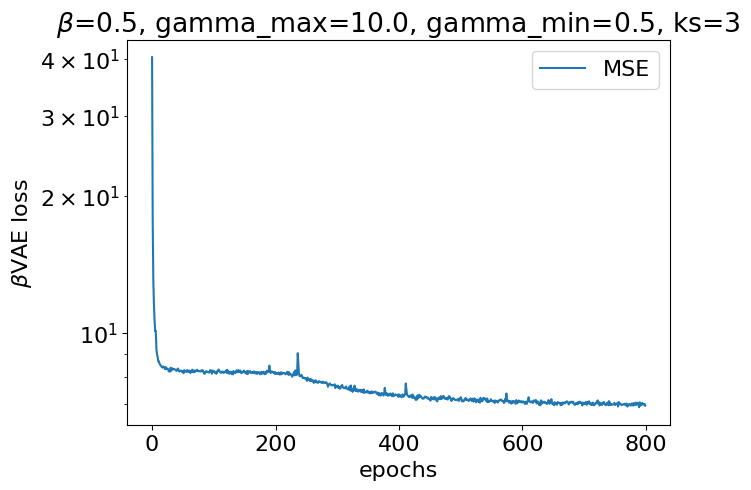

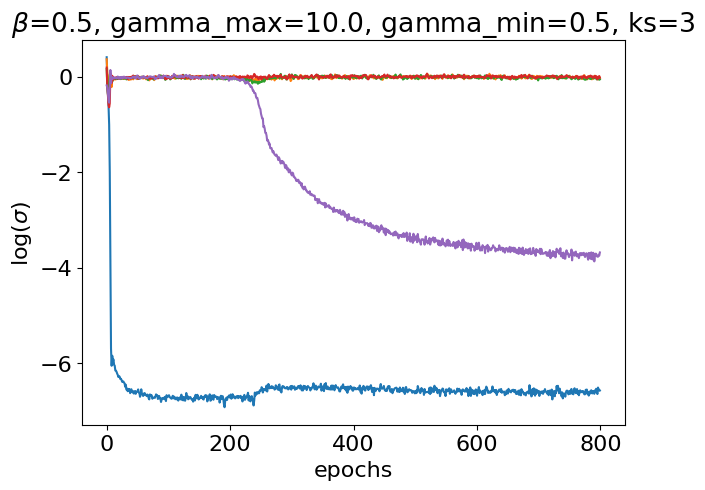

In [ ]:
history_logvar = data['history_logvar']
history_loss_RC = data['history_loss_RC']
history_loss_KL = data['history_loss_KL']

plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,5),dpi=100)

plt.semilogy(history_loss_RC,color=sns.color_palette('Paired')[1], label="MSE")
#plt.semilogy(beta*jnp.array(history_loss_KL),color=sns.color_palette('Paired')[9], label=r'$\beta$KL')

plt.legend()
#plt.xlim([-10,500])
plt.xlabel('epochs')
plt.ylabel(r'$\beta$VAE loss')
plt.title(r'$\beta$={}, gamma_max={}, gamma_min={}, ks={}'.format(beta,gamma_max, gamma_min, kernel_size))
plt.show()

plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,5),dpi=100)

plt.plot([jnp.mean(history_logvar[i], axis=0) for i in range(len(history_logvar))])
plt.xlabel('epochs')
plt.ylabel(r'$\log(\sigma)$')
plt.title(r'$\beta$={}, gamma_max={}, gamma_min={}, ks={}'.format(beta,gamma_max, gamma_min, kernel_size))
plt.show()

##### Latents

In [ ]:
#GET LATENT VARIABLES FOR THE WHOLE SPACE

latent_dim = 5
enc_lat = Encoder_and_latent(latent_dim=latent_dim,kernel_size=kernel_size)
get_latent_var = jax.jit(enc_lat.apply)
hi = nk.hilbert.Spin(s=1/2, N=N)
decoder = ARNNDense(hilbert=hi, layers= 3, features=4*N)


all_mean = jnp.zeros((len(all_alpha),len(all_h),latent_dim))
all_mean_abs = jnp.zeros((len(all_alpha),len(all_h),latent_dim))
all_logvar = jnp.zeros((len(all_alpha),len(all_h),latent_dim))
all_all_mean = jnp.zeros((len(all_alpha),len(all_h),jnp.shape(dataset)[2],latent_dim))

params = data['params']
params_encoder = params[0]


for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):

      d = testset[i,j]#[batch_size*b:batch_size*(b+1),:]
      means, logvar, z  = get_latent_var({'params': params_encoder}, d, key)

      all_mean = all_mean.at[i,j].set(jnp.mean(means,axis=0))
      #all_mean_abs = all_mean_abs.at[i,j].set(jnp.mean(jnp.abs(means),axis=0))
      all_all_mean = all_all_mean.at[i,j].set(means)
      all_logvar = all_logvar.at[i,j].set(jnp.mean(logvar,axis=0))

      #all_mean = all_mean.at[i,j].set(mean)
      #all_logvar = all_logvar.at[i,j].set(logvar)



idx = jnp.argsort(jnp.mean(all_logvar, axis=(0,1)))#[:3]


In [ ]:
latvar = {'mu0': all_all_mean[:,:,:,idx[0]], 'logvar0': all_logvar[:,:,idx[0]]}

with open('LRTFIM20_latentvar_ARconv_1lat.pkl', 'wb') as f:
  pickle.dump(latvar, f)

In [ ]:
latvar = {'mu0': all_all_mean[:,:,:,idx[0]], 'mu1': all_all_mean[:,:,:,idx[1]], 'logvar0': all_logvar[:,:,idx[0]], 'logvar1': all_logvar[:,:,idx[1]]}

with open('LRTFIM20_latentvar_ARconv.pkl', 'wb') as f:
  pickle.dump(latvar, f)

In [ ]:
c = {'mu2':all_all_mean[:,:,:,idx[1]], 'dataset':dataset}
with open('LRFIM20_mu2_SR.pkl', 'wb') as f:
  pickle.dump(c, f)

##### Sampling

In [ ]:
def get_sample_fast(model, params, latent_var, key):
    r"""
    get sample from NN in $s \in {-1, 1}$, just one sample for now
    params: Parameters of classical model
    model: Netket ARNN model
    latent_var: latent variable
    """
    size_batch = jnp.shape(latent_var)[0]
    latent_dim = jnp.shape(latent_var)[1]

    N = 20

    def scan_fn(carry, i):
        samples, key = carry
        p = model.apply(params, samples, method=model.conditionals)[:, i, :]
        local_states = jnp.array([-1, 1])
        key, subkey = jax.random.split(key)
        spin_value_sampled = nkjax.batch_choice(subkey, local_states, p)
        samples = samples.at[:, i].set(spin_value_sampled)
        return (samples, key), None

    # Initialize the carry with an empty array for samples and the key
    initial_samples = jnp.zeros((size_batch, N + latent_dim))
    initial_samples = initial_samples.at[:, 0:latent_dim].set(latent_var)
    carry = (initial_samples, key)

    # Perform the scan
    carry, _ = jax.lax.scan(scan_fn, carry, jnp.arange(latent_dim, N + latent_dim))

    # Extract the samples
    samples = carry[0][:, latent_dim:]

    return samples


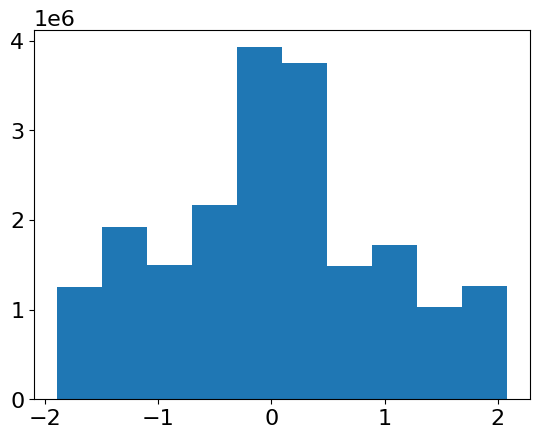

In [ ]:
nbr_mu = 1000

mu_hist = plt.hist(all_all_mean[:,:,:,idx[0]].reshape(-1))[1]
mu1 = jnp.linspace(mu_hist[0],mu_hist[-1],nbr_mu)
params = data['params']
params_encoder = params[0]
params_decoder = params[1]

key = jax.random.PRNGKey(42)

nbr_samples = 1000
all_S_mu1 = jnp.zeros((jnp.shape(mu1)[0],nbr_samples, N))


for i,k in enumerate(mu1):

    mu = k*jnp.ones((nbr_samples,))
    z = jnp.zeros((nbr_samples,5))
    z = z.at[:,idx[0]].set(mu)
    key, _ = jax.random.split(key)
    S = get_sample_fast(decoder,params_decoder,z,key)

    all_S_mu1 = all_S_mu1.at[i,:].set(S)


In [ ]:
with open('LRFIM20_dataset3_sampling_from_lat_ARconv_1lat.pkl', 'wb') as f:
    pickle.dump(all_S_mu1, f)

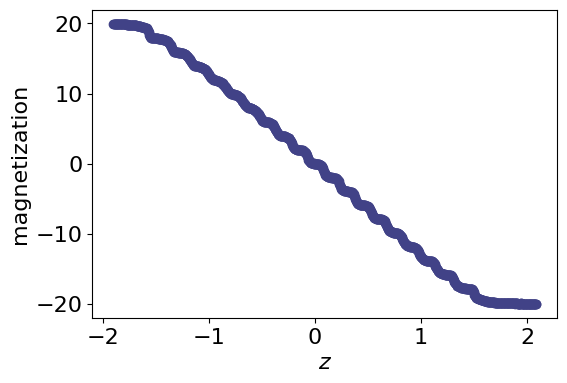

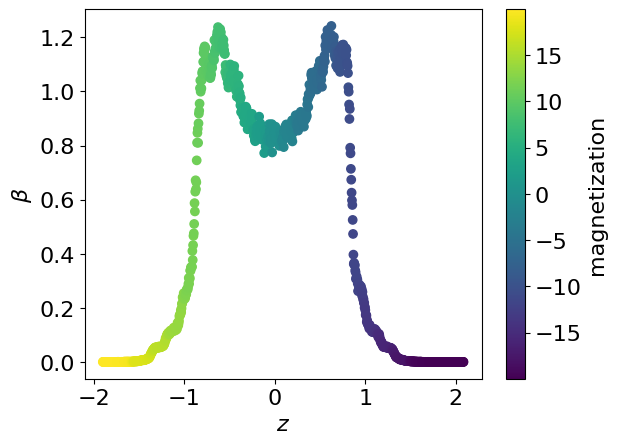

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)

color = sns.color_palette("viridis",as_cmap=True).colors[50]

magnetization_mu = jnp.mean(jnp.sum(all_S_mu1,axis=-1),axis=-1).reshape(-1)
plt.scatter(mu1,magnetization_mu, color = color)
plt.xlabel(r'$z$')
plt.ylabel(r'magnetization')
plt.show()



beta_mu = jnp.mean(jnp.abs(compute_beta_power_law_from_spins_vmap(all_S_mu1)), axis=-1)
plt.scatter(mu1,beta_mu, c=magnetization_mu)
cbar = plt.colorbar()
cbar.set_label(r'magnetization')
plt.xlabel(r'$z$')
plt.ylabel(r'$\beta$')
plt.show()

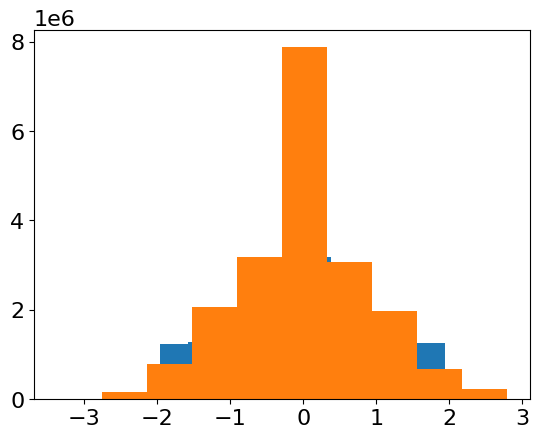

In [ ]:
nbr_mu = 100

mu1_hist = plt.hist(all_all_mean[:,:,:,idx[0]].reshape(-1))[1]
mu1 = jnp.linspace(mu1_hist[0],mu1_hist[-1],nbr_mu)
mu2_hist = plt.hist(all_all_mean[:,:,:,idx[1]].reshape(-1))[1]
mu2 = jnp.linspace(-3,3,nbr_mu)

params_encoder = params[0]
params_decoder = params[1]

key = jax.random.PRNGKey(42)

nbr_samples = 1000
#N = 20
all_S_mu12 = jnp.zeros((jnp.shape(mu1)[0],jnp.shape(mu2)[0],nbr_samples, N))

for j,k in enumerate(mu1):
    for i,k in enumerate(mu2):

        m1 = mu1[j]*jnp.ones((nbr_samples,))
        m2 = mu2[i]*jnp.ones((nbr_samples,))

        z = jnp.zeros((nbr_samples,5))
        z =  z.at[:,idx[0]].set(m1)
        z = z.at[:,idx[1]].set(m2)
        key, _ = jax.random.split(key)
        S = get_sample_fast(decoder,params_decoder,z,key)

        all_S_mu12 = all_S_mu12.at[j,i,:].set(S)


In [ ]:
with open('LRFIM20_dataset3_sampling_from_lat_ARconv_2lat.pkl', 'wb') as f:
    pickle.dump(all_S_mu12, f)

In [ ]:
## GET SAMPLES FROM THE DECODER FOR THE WHOLE SPACE

#testset = dataset

latent_dim = 5
enc_lat = Encoder_and_latent(latent_dim=latent_dim, kernel_size=kernel_size)
get_latent_var = jax.jit(enc_lat.apply)
decoder = ARNNDense(hilbert=hi, layers= 3, features=4*N)


params = data['params']
params_encoder = params[0]
params_decoder = params[1]

key = jax.random.PRNGKey(42)

nbr_samples = 5000

all_S_phase_space = jnp.zeros((jnp.shape(dataset)[0],jnp.shape(dataset)[1],nbr_samples,jnp.shape(dataset)[3]))

for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):

      d = testset[i,j][:nbr_samples]
      key, _ = jax.random.split(key)
      means, logvar, z  = get_latent_var({'params': params_encoder}, d, key)
      key, _ = jax.random.split(key)
      S = get_sample_fast(decoder,params_decoder,z,key)

      all_S_phase_space = all_S_phase_space.at[i,j,:].set(S)


In [ ]:
with open('LRFIM20_dataset3_recon_x_ARconv_2lat.pkl', 'wb') as f:
    pickle.dump(all_S_phase_space, f)

In [ ]:
with open('LRFIM20_dataset3_recon_x_ARconv_1lat.pkl', 'wb') as f:
    pickle.dump(all_S_phase_space, f)

##### logvar behaviour

In [ ]:
@jax.jit
def spectral_entropy(seq):
    """ Spectral entropy of the spin config."""
    # FFT of the sequence.
    fft_values = jnp.fft.fft(seq)

    # Power spectrum
    power = jnp.abs(fft_values)**2

    # Normalize
    total_power = jnp.sum(power)
    probabilities = power / total_power

    # Shannon entropy of the power spectrum.
    entropy = -jnp.sum(jnp.where(probabilities > 0,
                                 probabilities * jnp.log(probabilities),
                                 0.0))
    return entropy


In [ ]:
states = data_exact['wave_fcts']
spec_entropy_mean = jnp.zeros((jnp.shape(states)[0],jnp.shape(states)[1]))

for i, alpha in enumerate(all_alpha):
  for j, h in enumerate(all_h):
      print('alpha: {}, h: {}'.format(alpha,h))
      c = []
      for k in range(1000):
        c.append(spectral_entropy(testset[i,j][k].astype(jnp.int32)))
      spec_entropy_mean = spec_entropy_mean.at[i,j].set(jnp.mean(jnp.array(c)))



alpha: 0.0, h: 0.0
alpha: 0.0, h: 1.0526315789473684
alpha: 0.0, h: 2.1052631578947367
alpha: 0.0, h: 3.1578947368421053
alpha: 0.0, h: 4.2105263157894735
alpha: 0.0, h: 5.263157894736842
alpha: 0.0, h: 6.315789473684211
alpha: 0.0, h: 7.368421052631579
alpha: 0.0, h: 8.421052631578947
alpha: 0.0, h: 9.473684210526315
alpha: 0.0, h: 10.526315789473683
alpha: 0.0, h: 11.578947368421051
alpha: 0.0, h: 12.631578947368421
alpha: 0.0, h: 13.68421052631579
alpha: 0.0, h: 14.736842105263158
alpha: 0.0, h: 15.789473684210526
alpha: 0.0, h: 16.842105263157894
alpha: 0.0, h: 17.894736842105264
alpha: 0.0, h: 18.94736842105263
alpha: 0.0, h: 20.0
alpha: 0.5263157894736842, h: 0.0
alpha: 0.5263157894736842, h: 1.0526315789473684
alpha: 0.5263157894736842, h: 2.1052631578947367
alpha: 0.5263157894736842, h: 3.1578947368421053
alpha: 0.5263157894736842, h: 4.2105263157894735
alpha: 0.5263157894736842, h: 5.263157894736842
alpha: 0.5263157894736842, h: 6.315789473684211
alpha: 0.5263157894736842, h: 

In [ ]:
with open('LRTFIM20_spactral_entropy_ARconv_2lat.pkl', 'wb') as f:
    pickle.dump(spec_entropy_mean, f)

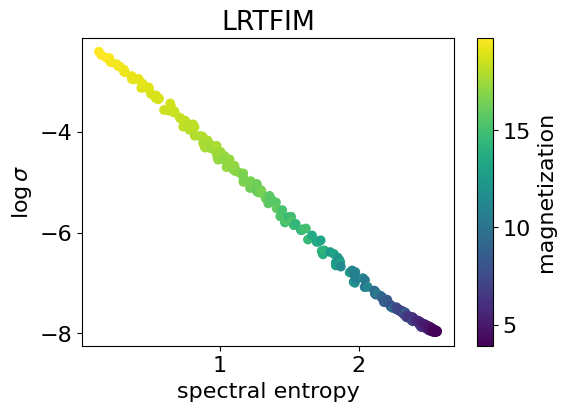

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)


idx_e = jnp.argsort(spec_entropy_mean.reshape(-1))
#c = jnp.mean(corr2,axis=-1).reshape(-1)
m = jnp.mean(jnp.abs(jnp.sum(testset,axis=-1)),axis=-1).reshape(-1)
beta_dataset = compute_beta_power_law_from_spins_vmap(dataset[:,:,:,:])
b = jnp.mean(beta_dataset,axis=-1).reshape(-1)
plt.scatter(spec_entropy_mean.reshape(-1)[idx_e], all_logvar[:,:,idx[0]].reshape(-1)[idx_e],c=m[idx_e], marker='o')
cbar = plt.colorbar()
cbar.set_label(r'magnetization')
plt.xlabel(r'spectral entropy')
plt.ylabel(r'$\log\sigma$')
plt.title(r'LRTFIM')
plt.show()

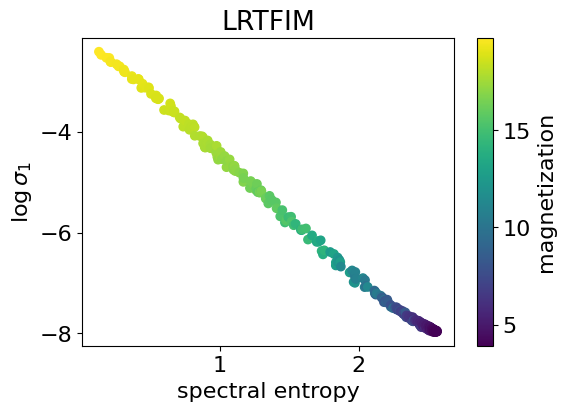

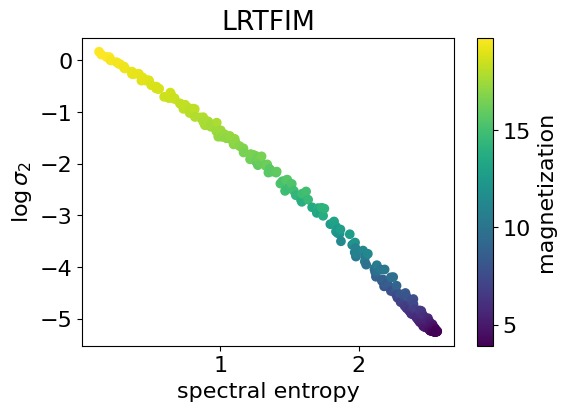

In [ ]:
import seaborn as sns
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)


idx_e = jnp.argsort(spec_entropy_mean.reshape(-1))
m = jnp.mean(jnp.abs(jnp.sum(testset,axis=-1)),axis=-1).reshape(-1)
beta_dataset = compute_beta_power_law_from_spins_vmap(dataset[:,:,:,:])
b = jnp.mean(beta_dataset,axis=-1).reshape(-1)
plt.scatter(spec_entropy_mean.reshape(-1)[idx_e], all_logvar[:,:,idx[0]].reshape(-1)[idx_e],c=m[idx_e], marker='o')
cbar = plt.colorbar()
cbar.set_label(r'magnetization')
plt.xlabel(r'spectral entropy')
plt.ylabel(r'$\log\sigma_1$')
plt.title(r'LRTFIM')
plt.show()

plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)

plt.scatter(spec_entropy_mean.reshape(-1)[idx_e], all_logvar[:,:,idx[1]].reshape(-1)[idx_e],c=m[idx_e], marker='o')
cbar = plt.colorbar()
cbar.set_label(r'magnetization')
plt.xlabel(r'spectral entropy')
plt.ylabel(r'$\log\sigma_2$')
plt.title(r'LRTFIM')
plt.show()